# Project Description

There are many types of rice available for production. It is essential to identify the type of rice as each produce needs different amounts of water manure, etc.

It is not possible for the farmers to pay the agriculture experts hefty fees every time they have a new produce. We have come up with a solution to this problem. We have trained an AI model which can be used by farmers to check the type of rice. The users need to upload image of a rice grain and click on the submit button. Our model will give its prediction for probable rice type based on the image. Our model can predict up to 5 different types of rice.

This model is useful for farmers, agriculture scientists, home farmers, gardeners, etc. This AI model is made using Convolutional Neural networks and under CNN we will be using transfer learning. Transfer learning has become one of the most common techniques that has achieved better performance in many areas, especially in image analysis and classification. We used Transfer Learning technique MobileNetv4 that is more widely used as a transfer learning method in image analysis, and it is highly effective.



# Importing Libraries

In [1]:
import kagglehub
import os
import shutil
import random
from pathlib import Path

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,InputLayer,Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2


import matplotlib.pyplot as plt
from PIL import Image

# Verify GPU is Available to TensorFlow

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and recognized by TensorFlow!")
    gpu_device_name = tf.config.list_physical_devices('GPU')[0].name
    print(f"GPU Device Name: {gpu_device_name}")
else:
    print("GPU is NOT available. Double-check runtime settings.")

GPU is available and recognized by TensorFlow!
GPU Device Name: /physical_device:GPU:0


# Loading Dataset

In [3]:
# Download latest version to Colab's default location (content directory)
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")
print("Path to dataset files:", path)

if os.path.exists(path):
    print("Dataset downloaded successfully.")
    # Get the current working directory
    current_directory = os.getcwd()
    print("Current working directory:", current_directory)

    # Construct the destination path in the current working directory
    destination_path = os.path.join(current_directory, "rice-image-dataset")

    # Copy the downloaded dataset to the current working directory
    try:
      shutil.copytree(path, destination_path)
      print(f"Dataset copied to: {destination_path}")
    except FileExistsError:
      print(f"A directory named 'rice-image-dataset' already exists in {current_directory}. Skipping copy operation.")
    except Exception as e:
      print(f"An error occurred during copying: {e}")
else:
    print("Dataset download failed.")


100%|██████████| 219M/219M [00:10<00:00, 21.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1
Dataset downloaded successfully.
Current working directory: /content
Dataset copied to: /content/rice-image-dataset


In [4]:
def count_files_per_folder(root_folder):
  file_counts = {}
  for subdir, _, files in os.walk(root_folder):
    # Exclude the root folder itself from the count.
    if subdir != root_folder:
        folder_name = os.path.basename(subdir)
        file_counts[folder_name] = len(files)
  return file_counts


dataset_path = "rice-image-dataset"
if os.path.exists(dataset_path):
    file_counts = count_files_per_folder(dataset_path)
    for folder, count in file_counts.items():
        print(f"Folder '{folder}': {count} files")
else:
    print(f"Error: The folder '{dataset_path}' does not exist.")


Folder 'Rice_Image_Dataset': 1 files
Folder 'Jasmine': 15000 files
Folder 'Basmati': 15000 files
Folder 'Karacadag': 15000 files
Folder 'Arborio': 15000 files
Folder 'Ipsala': 15000 files


# Preview of images

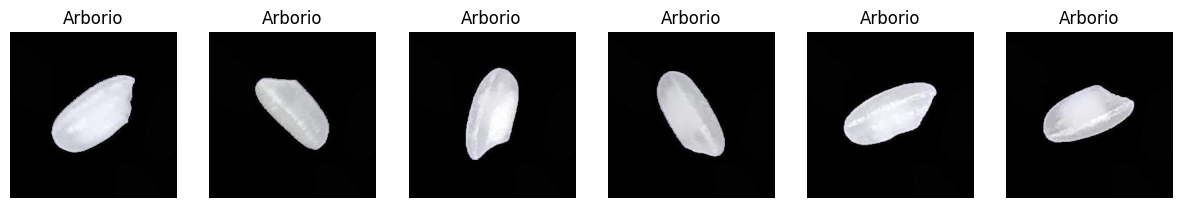

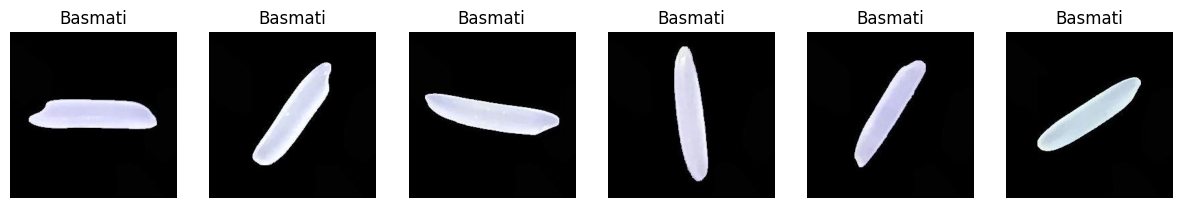

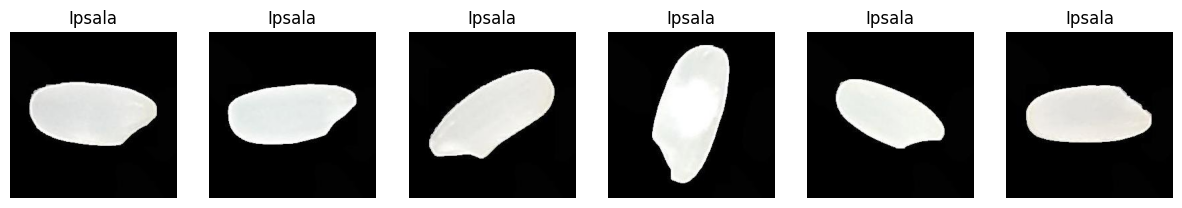

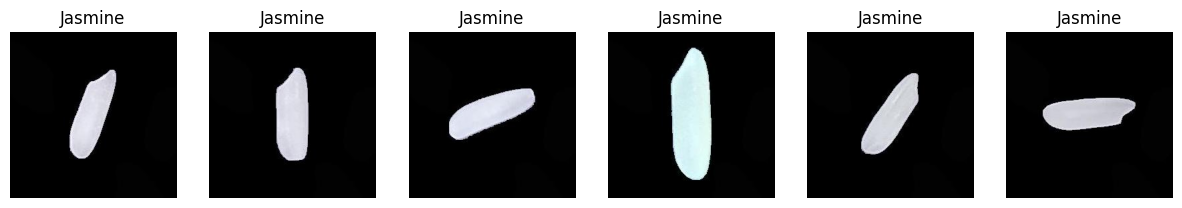

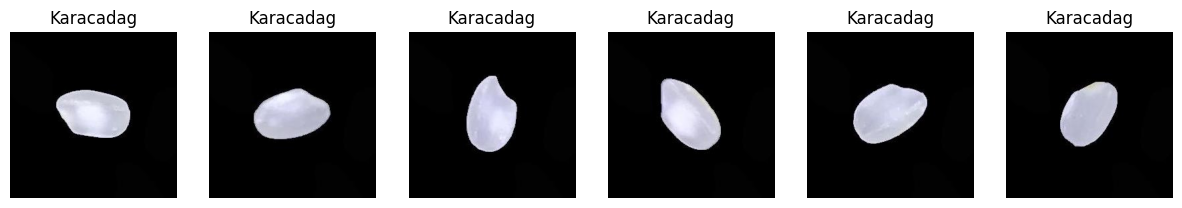

In [5]:
rice_types=["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

for rice_type in rice_types:

        image_dir = os.path.join("rice-image-dataset/Rice_Image_Dataset",rice_type)
        image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        selected_images = random.sample(image_files, min(6, len(image_files)))

        plt.figure(figsize=(15, 5))

        for i, image_file in enumerate(selected_images):
            image_path = os.path.join(image_dir, image_file)
            img = Image.open(image_path)
            plt.subplot(1, 6, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(rice_type)

# Directory Structure Creation

In [6]:
original_data_root = 'rice-image-dataset/Rice_Image_Dataset'
split_data_root = 'rice_dataset_split'
rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
random_seed = 42

# --- Create Directories ---
os.makedirs(split_data_root, exist_ok=True) # Main split directory
split_folders = ['train', 'val', 'test']
for split in split_folders:
    for rice_type in rice_types:
        os.makedirs(os.path.join(split_data_root, split, rice_type), exist_ok=True)

rng = np.random.RandomState(random_seed) # For reproducible splitting

# --- Copy Images to Split Folders ---
for rice_type_name in rice_types:
    image_dir = os.path.join(original_data_root, rice_type_name) # Path to original rice type folder
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))] # Get image filenames
    num_images = len(image_files)
    indices = np.arange(num_images)
    rng.shuffle(indices) # Shuffle indices

    train_split_index = int(train_ratio * num_images)
    val_split_index = train_split_index + int(val_ratio * num_images)

    train_indices = indices[:train_split_index]
    val_indices = indices[train_split_index:val_split_index]
    test_indices = indices[val_split_index:]

    for i in train_indices:
        src_path = os.path.join(image_dir, image_files[i])
        dst_path = os.path.join(split_data_root, 'train', rice_type_name, image_files[i])
        shutil.copyfile(src_path, dst_path) # Copy to train

    for i in val_indices:
        src_path = os.path.join(image_dir, image_files[i])
        dst_path = os.path.join(split_data_root, 'val', rice_type_name, image_files[i])
        shutil.copyfile(src_path, dst_path) # Copy to validation

    for i in test_indices:
        src_path = os.path.join(image_dir, image_files[i])
        dst_path = os.path.join(split_data_root, 'test', rice_type_name, image_files[i])
        shutil.copyfile(src_path, dst_path) # Copy to test

print(f"Data reorganized into directory structure at: {split_data_root}")

Data reorganized into directory structure at: rice_dataset_split


In [7]:
DATA_DIRECTORY = 'rice_dataset_split'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255) # Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255) # Only rescaling for testing

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIRECTORY, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIRECTORY, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIRECTORY, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No shuffle for test set
)

num_rice_classes = len(train_generator.class_indices)
print(f"Number of Rice Classes: {num_rice_classes}")

Found 60000 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.
Number of Rice Classes: 5


# Pre-trained CNN model as a Feature Extractor

In [8]:
mobile_net="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Wrap the KerasLayer in a Lambda layer for compatibility
feature_extractor = Lambda(lambda x: hub.KerasLayer(mobile_net, input_shape=(224, 224, 3), trainable=False)(x))


# Configure the Learning Process

In [9]:
model = Sequential([
    feature_extractor, # Using the wrapped KerasLayer
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [10]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f"rice.h5", save_best_only=True, monitor='val_loss')


# Train the model

In [ ]:
history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/10
1658/1875 ━━━━━━━━━━━━━━━━━━━━ 1:18 364ms/step - accuracy: 0.9518 - loss: 0.1341

In [ ]:
model.evaluate(test_generator)

In [ ]:
y_pred=model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)

print(classification_report(test_generator.classes,y_pred))